<a href="https://colab.research.google.com/github/Ortimus/nvidia-numba-basics/blob/main/gpu-acceleration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word Length Analysis with CUDA and Numba

This notebook demonstrates GPU acceleration using Numba for a simple text analysis task.

Key concepts covered:
- Basic CUDA kernel implementation
- Memory transfer between CPU and GPU
- Atomic operations
- Grid/block configuration

In [1]:
!pip install numba

In [2]:
import numpy as np
from numba import cuda, vectorize
import math
from time import time

## CPU Implementation
Basic sequential implementation for comparison

In [3]:
def count_word_lengths_cpu(words):
    max_length = 20
    counts = np.zeros(max_length, dtype=np.int32)
    for word in words:
        if len(word) < max_length:
            counts[len(word)] += 1
    return counts

## GPU Implementations
Two approaches: vectorized and CUDA kernel

In [4]:
# Approach 1: Vectorization
# This approach parallelizes a simple element-wise operation across the GPU
# vectorize decorator automatically handles the parallelization
# ['int32(int32)'] specifies input and output types for GPU compilation
# Good for simple element-wise operations that don't need thread coordination
@vectorize(['int32(int32)'], target='cuda')
def get_word_length(length):
    return min(length, 20)

# Approach 2: Custom CUDA Kernel
# This approach gives us more control over parallel execution
# We explicitly manage threads and memory access
@cuda.jit
def count_word_lengths_gpu(word_lengths, counts):
    # cuda.grid(1) gets the unique thread ID in a 1D grid
    # Each thread processes one element of the input array
    idx = cuda.grid(1)

    # Boundary check: ensure thread doesn't access beyond array bounds
    if idx < word_lengths.size:
        length = word_lengths[idx]
        if length < 20:
            # Atomic operation prevents race conditions
            # Multiple threads might try to increment the same count simultaneously
            # cuda.atomic.add ensures these updates happen safely
            cuda.atomic.add(counts, length, 1)

## Main Analysis Function

In [5]:
def analyze_text(text, use_gpu=True):
   # Split text into words and convert to numpy array for GPU processing
   words = text.split()
   word_lengths = np.array([len(word) for word in words], dtype=np.int32)

   # CPU path - direct counting
   if not use_gpu:
       return count_word_lengths_cpu(words)

   # GPU Memory Management:
   # cuda.to_device() transfers data from CPU (host) to GPU (device)
   # This is a key performance consideration - minimize these transfers
   d_lengths = cuda.to_device(word_lengths)  # Input array to GPU
   d_counts = cuda.to_device(np.zeros(20, dtype=np.int32))  # Output array initialized on GPU

   # CUDA Execution Configuration:
   # threadsperblock: number of threads that execute in parallel within each block
   # - Usually power of 2 (256 is common)
   # - Limited by GPU hardware (max 1024 on most GPUs)
   threadsperblock = 256

   # blockspergrid: number of blocks needed to process all data
   # - Calculate by: ceil(total_elements / threads_per_block)
   # - The division and rounding ensures we have enough blocks to process all elements
   blockspergrid = (word_lengths.size + threadsperblock - 1) // threadsperblock

   # Launch kernel with calculated grid configuration
   count_word_lengths_gpu[blockspergrid, threadsperblock](d_lengths, d_counts)

   # Transfer results back from GPU to CPU
   # Only done once at the end to minimize data transfer overhead
   return d_counts.copy_to_host()

## Test and Benchmark

In [6]:
# Create test data
words = ["python", "cuda", "gpu", "computing", "numba"] * 250000
text = " ".join(words)

# CPU benchmark
t0 = time()
cpu_counts = analyze_text(text, use_gpu=False)
cpu_time = time() - t0

# GPU benchmark
t0 = time()
gpu_counts = analyze_text(text, use_gpu=True)
gpu_time = time() - t0

print(f"CPU time: {cpu_time:.4f}s")
print(f"GPU time: {gpu_time:.4f}s")
print(f"Speedup: {cpu_time/gpu_time:.2f}x")

# Comprehensive benchmark and analysis functions

def benchmark_sizes(base_words, sizes=[10000, 100000, 1000000]):
   """Benchmark GPU performance across different data sizes"""
   results = []
   for size in sizes:
       words = base_words * size
       text = " ".join(words)

       # GPU timing
       t0 = time()
       gpu_counts = analyze_text(text, use_gpu=True)
       gpu_time = time() - t0

       # CPU timing
       t0 = time()
       cpu_counts = analyze_text(text, use_gpu=False)
       cpu_time = time() - t0

       results.append({
           'size': size,
           'gpu_time': gpu_time,
           'cpu_time': cpu_time,
           'speedup': cpu_time/gpu_time,
           'words_per_sec': size*len(base_words)/gpu_time
       })

   return results

def analyze_word_distribution(gpu_counts):
   """Statistical analysis of word length distribution"""
   lengths = np.arange(20)
   mean_length = np.average(lengths, weights=gpu_counts)
   std_length = np.sqrt(np.average((lengths - mean_length)**2, weights=gpu_counts))

   total_words = np.sum(gpu_counts)
   distribution = gpu_counts / total_words * 100
   return {
       'mean': mean_length,
       'std': std_length,
       'distribution': distribution
   }

def analyze_gpu_overhead(text):
   """Profile GPU memory transfer and computation times"""
   words = text.split()
   word_lengths = np.array([len(word) for word in words], dtype=np.int32)

   t0 = time()
   d_lengths = cuda.to_device(word_lengths)
   d_counts = cuda.to_device(np.zeros(20, dtype=np.int32))
   h2d_time = time() - t0

   t0 = time()
   threadsperblock = 256
   blockspergrid = (word_lengths.size + threadsperblock - 1) // threadsperblock
   count_word_lengths_gpu[blockspergrid, threadsperblock](d_lengths, d_counts)
   compute_time = time() - t0

   t0 = time()
   result = d_counts.copy_to_host()
   d2h_time = time() - t0

   return {
       'h2d_time': h2d_time,
       'compute_time': compute_time,
       'd2h_time': d2h_time,
       'total_time': h2d_time + compute_time + d2h_time
   }

# Benchmark section
base_words = ["python", "cuda", "gpu", "computing"]
size_results = benchmark_sizes(base_words)

# Print results
for result in size_results:
   print(f"\nDataset size: {result['size']} words")
   print(f"GPU time: {result['gpu_time']:.4f}s")
   print(f"CPU time: {result['cpu_time']:.4f}s")
   print(f"Speedup: {result['speedup']:.2f}x")
   print(f"Processing rate: {result['words_per_sec']:.0f} words/second")

# Analyze largest dataset
text = " ".join(base_words * size_results[-1]['size'])
gpu_counts = analyze_text(text, use_gpu=True)

stats = analyze_word_distribution(gpu_counts)
print(f"\nWord Length Statistics:")
print(f"Mean length: {stats['mean']:.2f}")
print(f"Std dev: {stats['std']:.2f}")
print("\nDistribution:")
for length, pct in enumerate(stats['distribution']):
   if pct > 0:
       print(f"{length} chars: {pct:.1f}%")

overhead = analyze_gpu_overhead(text)
total_time = overhead['total_time']
print(f"\nGPU Overhead Analysis:")
print(f"Host to Device: {overhead['h2d_time']*1000:.2f}ms ({overhead['h2d_time']/total_time*100:.1f}%)")
print(f"Computation: {overhead['compute_time']*1000:.2f}ms ({overhead['compute_time']/total_time*100:.1f}%)")
print(f"Device to Host: {overhead['d2h_time']*1000:.2f}ms ({overhead['d2h_time']/total_time*100:.1f}%)")

CPU time: 4.8480s
GPU time: 0.8622s
Speedup: 5.62x

Dataset size: 10000 words
GPU time: 0.0583s
CPU time: 0.2172s
Speedup: 3.73x
Processing rate: 686221 words/second

Dataset size: 100000 words
GPU time: 0.1391s
CPU time: 2.4188s
Speedup: 17.39x
Processing rate: 2875036 words/second

Dataset size: 1000000 words
GPU time: 1.2301s
CPU time: 11.3399s
Speedup: 9.22x
Processing rate: 3251812 words/second

Word Length Statistics:
Mean length: 5.50
Std dev: 2.29

Distribution:
3 chars: 25.0%
4 chars: 25.0%
6 chars: 25.0%
9 chars: 25.0%

GPU Overhead Analysis:
Host to Device: 4.85ms (56.9%)
Computation: 0.14ms (1.6%)
Device to Host: 3.54ms (41.5%)


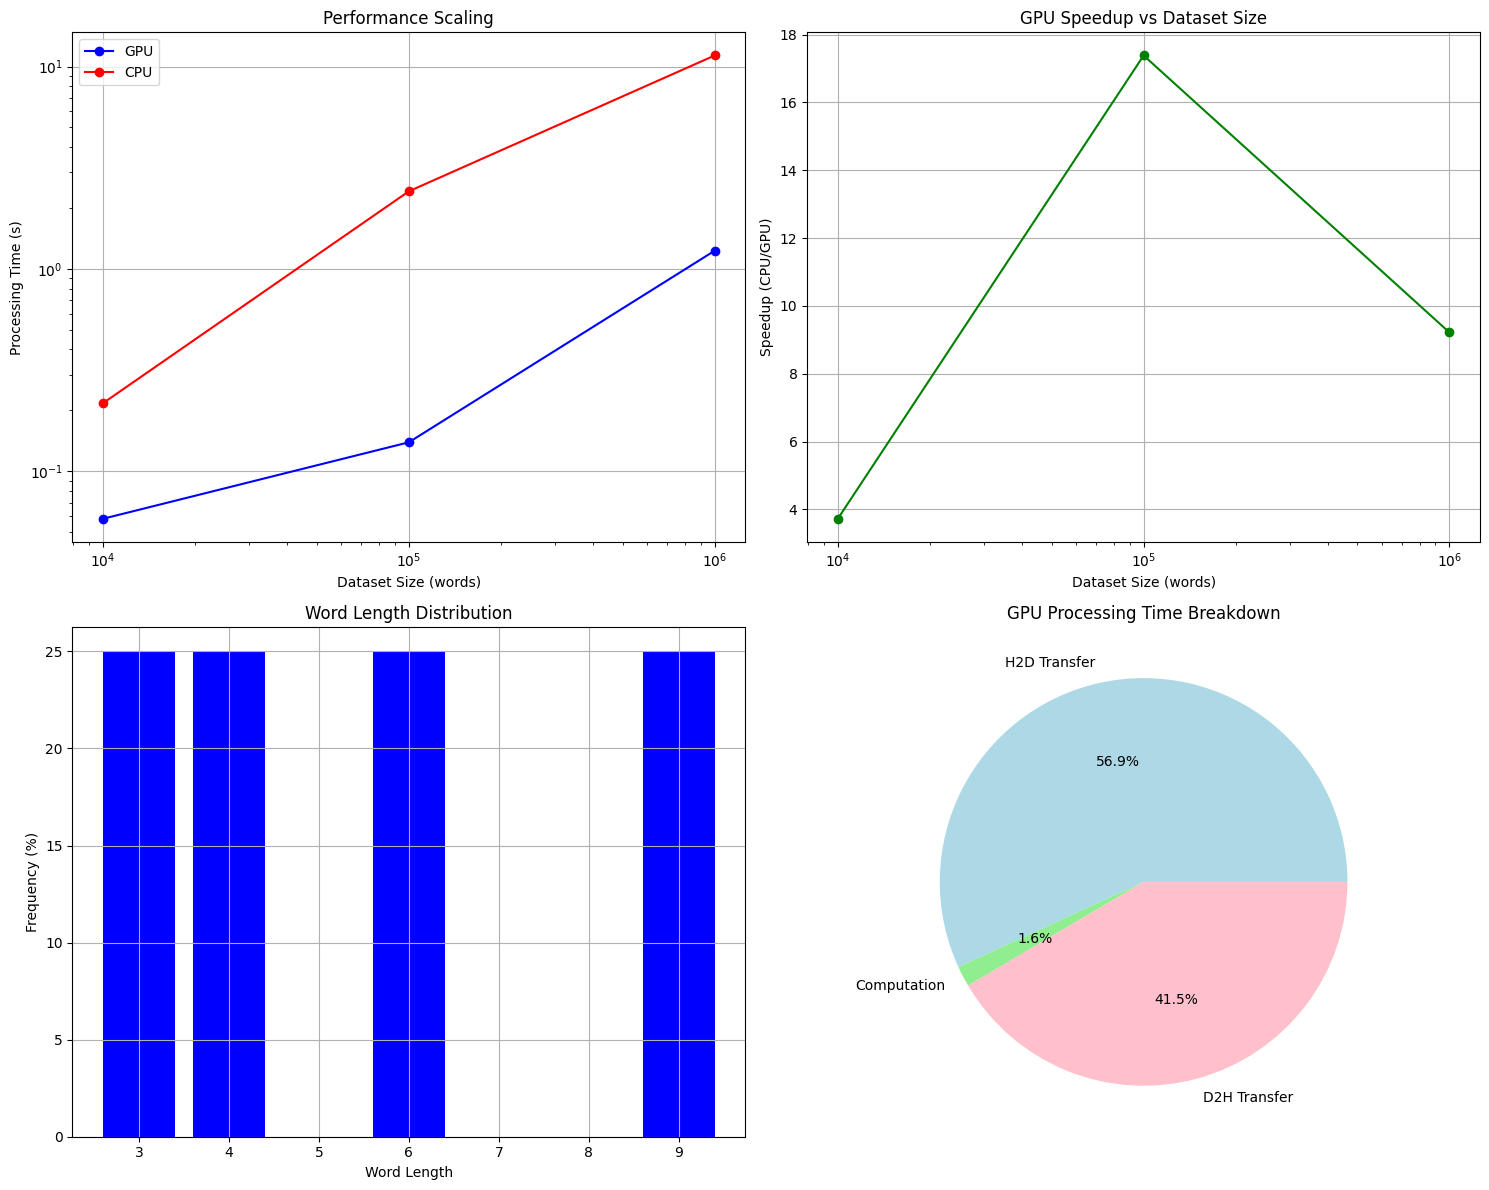

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_results(size_results, stats, overhead):
    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Performance Scaling
    sizes = [r['size'] for r in size_results]
    gpu_times = [r['gpu_time'] for r in size_results]
    cpu_times = [r['cpu_time'] for r in size_results]

    ax1.plot(sizes, gpu_times, 'o-', color='blue', label='GPU')
    ax1.plot(sizes, cpu_times, 'o-', color='red', label='CPU')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('Dataset Size (words)')
    ax1.set_ylabel('Processing Time (s)')
    ax1.set_title('Performance Scaling')
    ax1.grid(True)
    ax1.legend()

    # 2. Speedup vs Size
    speedups = [r['speedup'] for r in size_results]
    ax2.plot(sizes, speedups, 'o-', color='green')
    ax2.set_xscale('log')
    ax2.set_xlabel('Dataset Size (words)')
    ax2.set_ylabel('Speedup (CPU/GPU)')
    ax2.set_title('GPU Speedup vs Dataset Size')
    ax2.grid(True)

    # 3. Word Length Distribution
    lengths = np.arange(len(stats['distribution']))
    mask = stats['distribution'] > 0
    ax3.bar(lengths[mask], stats['distribution'][mask], color='blue')
    ax3.set_xlabel('Word Length')
    ax3.set_ylabel('Frequency (%)')
    ax3.set_title('Word Length Distribution')
    ax3.grid(True)

    # 4. GPU Time Breakdown
    labels = ['H2D Transfer', 'Computation', 'D2H Transfer']
    times = [overhead['h2d_time'], overhead['compute_time'], overhead['d2h_time']]
    ax4.pie(times, labels=labels, autopct='%1.1f%%', colors=['lightblue', 'lightgreen', 'pink'])
    ax4.set_title('GPU Processing Time Breakdown')

    plt.tight_layout()
    return fig

# Create visualizations
fig = visualize_results(size_results, stats, overhead)
plt.show()